In [8]:
import numpy as np
import matplotlib.pyplot as plt

main_data = np.loadtxt("Data.dat")

time = main_data[:, 0]
observed = main_data[:, 1]
calculated=main_data[:,2]
residuals=main_data[:,3]
point_weight=main_data[:,4]
point_error=main_data[:,5]

# Cargar periodos
periodos = np.loadtxt("freqs.per")
# Obtener frecuencias y parámetros de los periodos
freq1 = periodos[0, 0]  # Frecuencia principal (datos observados)
amp1 = periodos[0, 1]   # Amplitud
phase1 = periodos[0, 2] # Fase

freq2 = periodos[1, 0]  # Frecuencia secundaria
amp2 = periodos[1, 1]
phase2 = periodos[1, 2]

freq3 = periodos[2, 0]  # Frecuencia secundaria
amp3 = periodos[2, 1]
phase3 = periodos[2, 2]

freq4 = periodos[3, 0]  # Frecuencia secundaria
amp4 = periodos[3, 1]
phase4 = periodos[3, 2]

freq5 = periodos[4, 0]  # Frecuencia secundaria
amp5 = periodos[4, 1]
phase5 = periodos[4, 2]

freq6 = periodos[5, 0]  # Frecuencia secundaria
amp6 = periodos[5, 1]
phase6 = periodos[5, 2]


#Cargar transformadas de Fourier
tf_observed_f1=np.loadtxt("TF_1.fou")
tf_observed_freq1=tf_observed_f1[:,0]
tf_observed_amp1=tf_observed_f1[:,1]

tf_f2=np.loadtxt("TF_2.fou")
tf_freq2=tf_f2[:,0]
tf_amp2=tf_f2[:,1]

tf_f3=np.loadtxt("TF_3.fou")
tf_freq3=tf_f3[:,0]
tf_amp3=tf_f3[:,1]

tf_f4=np.loadtxt("TF_res_1.fou")
tf_freq4=tf_f4[:,0]
tf_amp4=tf_f4[:,1]

tf_f5=np.loadtxt("TF_res_2.fou")
tf_freq5=tf_f5[:,0]
tf_amp5=tf_f5[:,1]

tf_f6=np.loadtxt("TF_res_3.fou")
tf_freq6=tf_f6[:,0]
tf_amp6=tf_f6[:,1]

tf_spectral_window=np.loadtxt("Spectral_window.fou")
tf_spectral_window_freq=tf_spectral_window[:,0]
tf_spectral_window_amp=tf_spectral_window[:,1]

#Frequencies folded with spectral window
tf_f1_folded_w_sw=np.loadtxt("f1_ffwsw.fou") # main freeq
tf_f1_fwsw_freq=tf_f1_folded_w_sw[:,0]
tf_f1_fwsw_amp=tf_f1_folded_w_sw[:,1]

    # secondary freqs

tf_f2_folded_w_sw=np.loadtxt("f2_ffwsw.fou") 
tf_f2_fwsw_freq=tf_f2_folded_w_sw[:,0]
tf_f2_fwsw_amp=tf_f2_folded_w_sw[:,1]

tf_f3_folded_w_sw=np.loadtxt("f3_ffwsw.fou") 
tf_f3_fwsw_freq=tf_f3_folded_w_sw[:,0]
tf_f3_fwsw_amp=tf_f3_folded_w_sw[:,1]

tf_f4_folded_w_sw=np.loadtxt("f4_ffwsw.fou") 
tf_f4_fwsw_freq=tf_f4_folded_w_sw[:,0]
tf_f4_fwsw_amp=tf_f4_folded_w_sw[:,1]

tf_f5_folded_w_sw=np.loadtxt("f5_ffwsw.fou") 
tf_f5_fwsw_freq=tf_f5_folded_w_sw[:,0]
tf_f5_fwsw_amp=tf_f5_folded_w_sw[:,1]

tf_f6_folded_w_sw=np.loadtxt("f6_ffwsw.fou") 
tf_f6_fwsw_freq=tf_f6_folded_w_sw[:,0]
tf_f6_fwsw_amp=tf_f6_folded_w_sw[:,1]

#Spectrums noises
noise_spectrum=np.loadtxt("Spectrum_noise_original_data.dat")
ns_freqs=noise_spectrum[:,0]
ns_noise_amp=noise_spectrum[:,1]
  #residuals spectrum noise
noise_spectrum_residuals=np.loadtxt("Spectrum_noise_residuals.dat")
ns_freqs_res=noise_spectrum[:,0]
ns_res_noise_amp=noise_spectrum[:,1]

#Noise at frequencies
freq_noices=np.loadtxt("Noise_frequencies.dat")

f1=freq1
f1_noise_amp=freq_noices[0,1]
f1_snr=freq_noices[0,2]

f2=freq2
f2_noise_amp=freq_noices[1,1]
f2_snr=freq_noices[1,2]

f3=freq3
f3_noise_amp=freq_noices[2,1]
f3_snr=freq_noices[2,2]

f4=freq4
f4_noise_amp=freq_noices[3,1]
f4_snr=freq_noices[3,2]

f5=freq5
f5_noise_amp=freq_noices[4,1]
f5_snr=freq_noices[4,2]

f6=freq6
f6_noise_amp=freq_noices[5,1]
f6_snr=freq_noices[5,2]

In [3]:
import numpy as np

def check_harmonics(periodos, time, max_n=12, tol=None, tol_factor=3):
    """
    periodos: array-like shape (N, >=3) where column 0 freq, col1 amp, col2 phase (radians)
    time: array-like times used to compute T (same units as frequencies inverse)
    max_n: máximo múltiplo entero a probar (por si hay armónicos altos)
    tol: tolerancia absoluta en frecuencia (None -> se usa tol_factor * resolution)
    tol_factor: multiplicador de la resolución (si tol None)
    
    Retorna lista de dicts por cada frecuencia con info sobre el candidato armónico.
    """
    periodos = np.asarray(periodos)
    f1 = periodos[0,0]
    phase1 = periodos[0,2]
    T = np.max(time) - np.min(time)
    if T <= 0:
        raise ValueError("time debe tener duración positiva")
    resolution = 1.0 / T
    
    if tol is None:
        tol = tol_factor * resolution
    
    results = []
    for i, row in enumerate(periodos):
        fi = float(row[0])
        ampi = row[1]
        phasei = row[2]
        if i == 0:
            results.append({
                "index": i,
                "fi": fi,
                "is_fundamental": True,
                "n_candidate": 1,
                "freq_diff": 0.0,
                "freq_diff_rel": 0.0,
                "within_tol": True,
                "expected_phase": phase1 % (2*np.pi),
                "phase_diff": 0.0
            })
            continue

        # calcular n entero más cercano
        n_best = int(round(fi / f1))
        # asegurar n >= 1 y <= max_n
        if n_best < 1:
            n_best = 1
        if n_best > max_n:
            # si el entero más cercano > max_n, aún lo guardamos pero marcamos
            pass

        f_expected = n_best * f1
        diff = fi - f_expected
        diff_abs = abs(diff)
        diff_rel = diff_abs / fi if fi != 0 else np.nan
        within = diff_abs <= tol

        # fase esperada (tomando módulo 2pi)
        phase_expected = (n_best * phase1) % (2*np.pi)
        # diferencia de fase circular en [-pi, pi]
        dphase = (phasei - phase_expected + np.pi) % (2*np.pi) - np.pi
        dphase_abs = abs(dphase)

        results.append({
            "index": i,
            "fi": fi,
            "amp": ampi,
            "phase": phasei,
            "n_candidate": n_best,
            "f_expected": f_expected,
            "freq_diff": diff,
            "freq_diff_abs": diff_abs,
            "freq_diff_rel": diff_rel,
            "resolution": resolution,
            "tol_used": tol,
            "within_tol": within,
            "expected_phase": phase_expected,
            "phase_diff_rad": dphase,
            "phase_diff_deg": np.degrees(dphase),
            "phase_consistent": dphase_abs < 0.5  # umbral: 0.5 rad (~29°); ajustable
        })

    return results


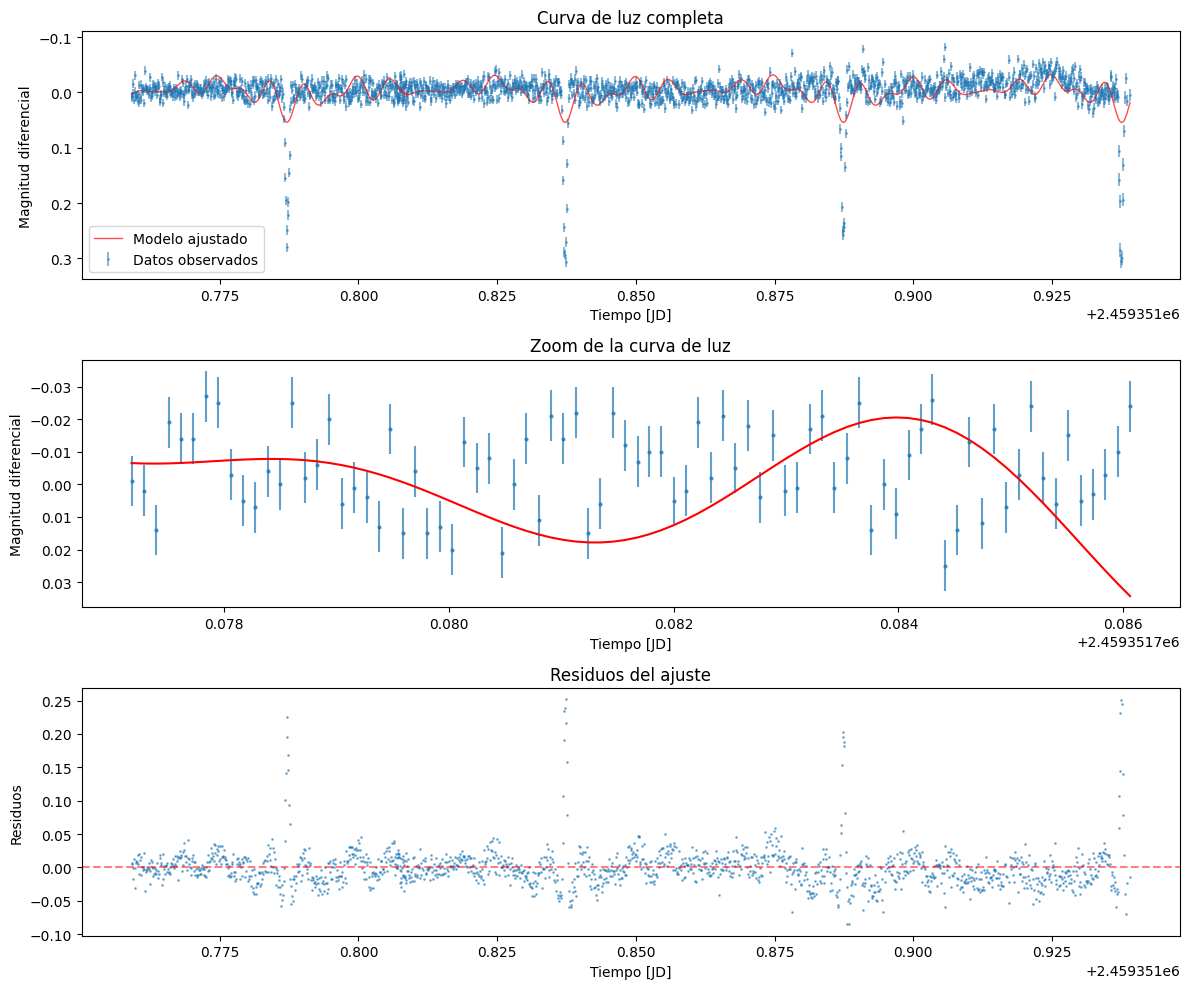

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Curva de luz completa
axes[0].errorbar(time, observed, yerr=point_error, fmt='.', markersize=2, 
                 alpha=0.5, label='Datos observados')
axes[0].plot(time, calculated, 'r-', linewidth=1, alpha=0.7, label='Modelo ajustado')
axes[0].set_xlabel('Tiempo [JD]')
axes[0].set_ylabel('Magnitud diferencial')
axes[0].set_title('Curva de luz completa')
axes[0].legend()
axes[0].invert_yaxis()  # Magnitudes más brillantes hacia arriba

# Zoom a una sección
time_span = time[-1] - time[0]
zoom_start = time[0] + 0.1*time_span
zoom_end = time[0] + 0.15*time_span
mask = (time >= zoom_start) & (time <= zoom_end)

axes[1].errorbar(time[mask], observed[mask], yerr=point_error[mask], 
                 fmt='.', markersize=4, alpha=0.7)
axes[1].plot(time[mask], calculated[mask], 'r-', linewidth=1.5)
axes[1].set_xlabel('Tiempo [JD]')
axes[1].set_ylabel('Magnitud diferencial')
axes[1].set_title('Zoom de la curva de luz')
axes[1].invert_yaxis()

# Residuos
axes[2].scatter(time, residuals, s=1, alpha=0.5)
axes[2].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Tiempo [JD]')
axes[2].set_ylabel('Residuos')
axes[2].set_title('Residuos del ajuste')

plt.tight_layout()
plt.show()